In [33]:
import urllib.request
import pandas as pd
import zipfile
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon

In [ ]:
# Taken from:
# https://towardsdatascience.com/how-to-calculate-travel-time-for-any-location-in-the-world-56ce639511f
# https://hub.mybinder.turing.ac.uk/user/shakasom-isochronewithosmnx-orjzja61/notebooks/Isochrones.ipynb


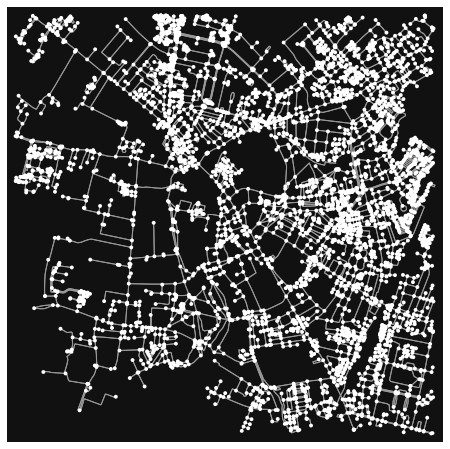

<Figure size 432x288 with 0 Axes>

In [22]:
# 1. Place you are interested
place = "Cambridge, England"
# 2. Transportation mode
mode = "walk"
# 3. Create network graph from place and mode
G = ox.graph_from_address(place, dist = 2000, simplify=True, network_type=mode)
# 4. Plot the network graph
fig, ax = ox.plot_graph(G);
plt.tight_layout()
plt.show()

In [43]:
# Trip time in Mintues
trip_times = [5, 10, 20, 30, 40]

# walking speed in km/hour
travel_speed = 4.5

# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [44]:
# node map centred on The City Centre Medical Practice - Cambridge

point_of_interest = ox.distance.nearest_nodes(G, X =0.12080723312113517, Y=52.20557515510201,) # X = longitude, Y = Latitude


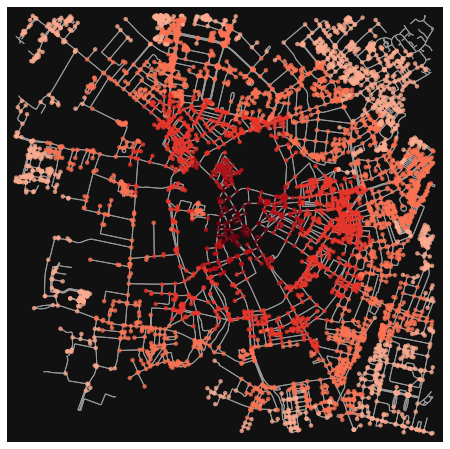

In [45]:
# 1 - get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
# 2 - color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)


In [46]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, point_of_interest, radius=trip_time, distance='time')
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

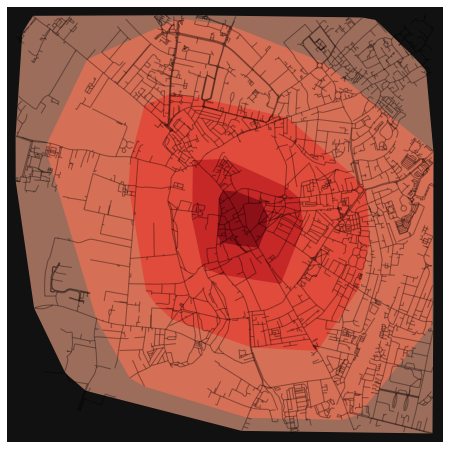

In [47]:
fig, ax = ox.plot.plot_graph(G, show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

In [ ]:
#GP Practice data ingestion

url = 'https://files.digital.nhs.uk/assets/ods/current/epraccur.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
first_file = zip_file_object.namelist()[0]
file = zip_file_object.open(first_file)
content = file.read()
csv_file = open('data/epraccur_data.csv', 'wb')
csv_file.write(content)
csv_file.close()
header_list = ["Organisation Code", "Name", "National Grouping", "High Level Health Geography", "Address line 1", "Address line 2", "Address line 3", 
"Address line 4", "Address line 5","Postcode","Open Date","Close Date","Status Code","Organisation Sub-Type Code","Commissioner","Join Provider/Purchaser Date",
"Left Provider/Purchaser Date","Contact Telephone Number", "Null 1", "Null 2", "Null 3", "Amended Record Indicator", "Null 4", "Provider/Purchaser",
"Null 5", "Prescribing Setting", "Null 6"]

In [ ]:
gp_practice_df = pd.read_csv('data/epraccur_data.csv', names=header_list)
gp_practice_df